## Análisis de resultados.
En esta hoja de notas queremos comparar los resultados extraidos del DR3 de los obtenidos en el DR2 en el trabajo 
[Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

## Requirements

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from dotenv import load_dotenv
from google.cloud import storage

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.utils import read_catalog_file
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_project
from hyper_velocity_stars_detection.cluster_detection.cluster_detection import get_distance_from_references


load_dotenv("../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/hvs-storage.json"
PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Resultados Previos
Resultados en el DR2 en el trabajo [Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

In [2]:
v = Vizier(columns=["Name", "Rsun", "e_Rsun", "pmRA*", "e_pmRA*", "pmDE", "e_pmDE", "RV", "e_RV", "rho"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs("J/MNRAS/482/5138")
clusters_dr2 = catalogs[0].to_pandas()
clusters_dr2.Name = clusters_dr2.Name.str.lower()

clusters_dr2["parallax"] = 1 / (clusters_dr2.Rsun)
clusters_dr2["e_parallax"] = (1 / (clusters_dr2.Rsun - clusters_dr2.e_Rsun) - 1 / (clusters_dr2.Rsun + clusters_dr2.e_Rsun)) / 2
clusters_dr2 = clusters_dr2[["Name","parallax", "e_parallax", "pmRA_", "e_pmRA_", "pmDE", "e_pmDE", "RV", "e_RV", "rho", "Rsun", "e_Rsun"]]
clusters_dr2 = clusters_dr2.rename(columns={"pmRA_": "pmra", "pmDE": "pmdec", "parallax": "parallax_corrected"})
clusters_dr2

,Name,parallax_corrected,e_parallax,pmra,e_pmRA_,pmdec,e_pmDE,RV,e_RV,rho,Rsun,e_Rsun
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,4.430000,0.04
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,9.980000,0.33
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,9.170000,0.26
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,31.299999,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,15.490000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,10.510000,0.37
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,8.000000,0.57
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,19.000000,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,24.799999,NaN


Extraemos la información de la relación masa luminosidad de los cluster del trabajo [McLaughlin & van der Marel, 2005](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/ApJS/161/304/table13&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa)

In [3]:
catalog2= "J/ApJS/161/304/table13"
catalog1 = "J/ApJS/161/304/clusters"
catalog2= "J/ApJS/161/304/models"

v = Vizier(columns=["**"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs([catalog1, catalog2])
clusters_ml = catalogs[0].to_pandas()
tbl_2 = catalogs[1].to_pandas()

properties = ["Ltot", "Mtot", "M_L"]
for prop in properties:
    df_p = tbl_2[["Cluster", prop, f"e_{prop}", f"E_{prop}"]].sort_values(["Cluster", f"e_{prop}", f"E_{prop}"])
    clusters_ml = pd.merge(clusters_ml, df_p.groupby("Cluster").first().reset_index(), on="Cluster")

clusters_ml.SName = clusters_ml.SName.str.lower()
clusters_ml

,recno,Cluster,RAJ2000,DEJ2000,SB,M,D,SName,logAge,__Fe_H_,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,1,FORNAX1,02 37 02.1,-34 11 00,SB,M,,name fornax 1,10.11,-2.20,...,0.147,4.12,0.03,0.03,4.40,0.05,0.05,1.915,0.163,0.163
1,2,FORNAX2,02 38 40.1,-34 48 05,SB,M,,name fornax 2,10.11,-1.78,...,0.145,4.80,0.04,0.04,5.07,0.05,0.05,1.867,0.156,0.156
2,3,FORNAX3,02 39 52.5,-34 16 08,SB,M,D,name fornax 3,10.11,-1.96,...,0.145,5.13,0.04,0.04,5.40,0.05,0.05,1.880,0.159,0.159
3,4,FORNAX4,02 40 07.9,-34 32 19,SB,M,D,name fornax 4,10.06,-1.90,...,0.076,4.94,0.05,0.05,5.18,0.05,0.05,1.717,0.075,0.075
4,5,FORNAX5,02 42 21.1,-34 06 05,SB,M,D,name fornax 5,10.11,-2.20,...,0.147,4.82,0.04,0.04,5.10,0.05,0.05,1.915,0.163,0.163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,212,SMC-NGC339,00 57 48.9,-74 28 00,SB,M,,ngc 339,9.80,-1.50,...,0.117,4.87,0.05,0.06,4.90,0.07,0.07,1.088,0.104,0.104
149,213,SMC-NGC361,01 02 12.8,-71 36 16,SB,M,,ngc 361,9.91,-1.45,...,0.109,5.18,0.08,0.09,5.30,0.08,0.10,1.313,0.101,0.101
150,214,SMC-NGC411,01 07 56.0,-71 46 05,SB,M,,ngc 411,9.15,-0.68,...,0.038,4.86,0.05,0.05,4.47,0.10,0.10,0.410,0.080,0.080
151,215,SMC-NGC416,01 07 59.0,-72 21 20,SB,M,,ngc 416,9.84,-1.44,...,0.102,5.14,0.04,0.04,5.21,0.05,0.05,1.181,0.084,0.084


In [4]:
df_clusters = pd.merge(clusters_dr2, clusters_ml, left_on=["Name"], right_on="SName", how="left")
df_clusters

,Name,parallax_corrected,e_parallax,pmra,e_pmRA_,pmdec,e_pmDE,RV,e_RV,rho,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,...,0.224,5.68,0.01,0.01,6.05,0.04,0.04,2.348,0.239,0.239
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,...,0.186,4.56,0.01,0.01,4.85,0.04,0.04,1.972,0.165,0.165
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,...,0.190,5.23,0.01,0.01,5.53,0.04,0.04,2.013,0.171,0.171
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,...,0.180,4.94,0.00,0.00,5.20,0.04,0.04,1.928,0.158,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,...,0.157,5.57,0.01,0.01,5.84,0.04,0.04,1.872,0.154,0.154
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Resultados DR3

In [ ]:
CLUSTER_NAME = "ngc 104"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)
print(str(project))

In [11]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=True
)

AttributeError: 'NoneType' object has no attribute 'selected_hvs'

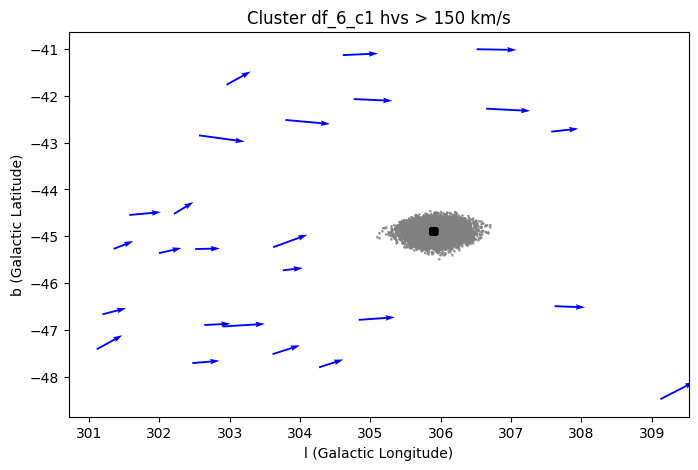

In [109]:
fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)

In [110]:
df_hvs_candidates = project.get_data("df_6_c1")
selected = project.clustering_results.selected_hvs(df_hvs_candidates, 1, 150)
selected["pm_kms"] - project.clustering_results.gc.pm_kms.mean()

260     165.087713
316     296.604899
391     247.985955
449     205.983710
477     244.837670
589     415.855424
605     316.208705
663     160.225098
697     222.945566
727     171.953212
759     195.909363
824     332.633766
851     182.831074
884     161.261785
896     201.449003
1180    167.230453
1266    155.650644
1327    177.970437
1348    243.978670
1373    239.707200
1405    168.891147
1580    463.664101
1637    217.714111
1793    184.068695
1797    174.593466
Name: pm_kms, dtype: float64

### Reclustering

*Añadir una comprobación de varianza extra-cluster, es decir, que exista diferencias entre cluster.*

In [8]:
data_name = "df_1_c2"

if project.get_data(data_name).shape[0] < 16000:
    data_name = "df_1_c0"

columns_to_clus=["ra", "dec", "pmra", "pmdec", "parallax_corrected"]
columns=["pmra", "pmdec", "parallax_corrected"]

print("Datos seleccionados: %s" %data_name)

clustering = project.optimize_cluster_detection(
    data_name=data_name,
    columns=columns, 
    columns_to_clus=columns_to_clus,
    max_cluster=4,
    n_trials=10
)

[I 2025-05-26 20:19:00,234] A new study created in memory with name: no-name-686dd952-3e44-4add-bdec-e69b7db16f61


Datos seleccionados: df_1_c2


[I 2025-05-26 20:19:01,413] Trial 0 finished with value: 5.0871540238309105 and parameters: {'params_distribution': 'hdbscan', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 4, 'hdbscan_metric': 'l2', 'hdbscan_algorithm': 'auto', 'hdbscan_scaler_method': None, 'hdbscan_noise_method': 'isolation_forest_method'}. Best is trial 0 with value: 5.0871540238309105.
[I 2025-05-26 20:19:06,734] Trial 1 finished with value: 0.7655135102939014 and parameters: {'params_distribution': 'hdbscan', 'hdbscan_min_cluster_size': 55, 'hdbscan_min_samples': 4, 'hdbscan_metric': 'l2', 'hdbscan_algorithm': 'brute', 'hdbscan_scaler_method': None, 'hdbscan_noise_method': None}. Best is trial 1 with value: 0.7655135102939014.
[I 2025-05-26 20:19:07,987] Trial 2 finished with value: 8.918617758719359 and parameters: {'params_distribution': 'hdbscan', 'hdbscan_min_cluster_size': 43, 'hdbscan_min_samples': 6, 'hdbscan_metric': 'manhattan', 'hdbscan_algorithm': 'ball_tree', 'hdbscan_scaler_method': 'minmax'

In [9]:
project.clustering_results.clustering

ClusteringDetection(model=HDBSCAN(min_cluster_size=63, min_samples=9), scaler=StandardScaler(), noise_method=LocalOutlierNoise(model=LocalOutlierFactor()), labels_=array([ 0, -1, -1, ...,  1,  1,  1], shape=(16653,)))

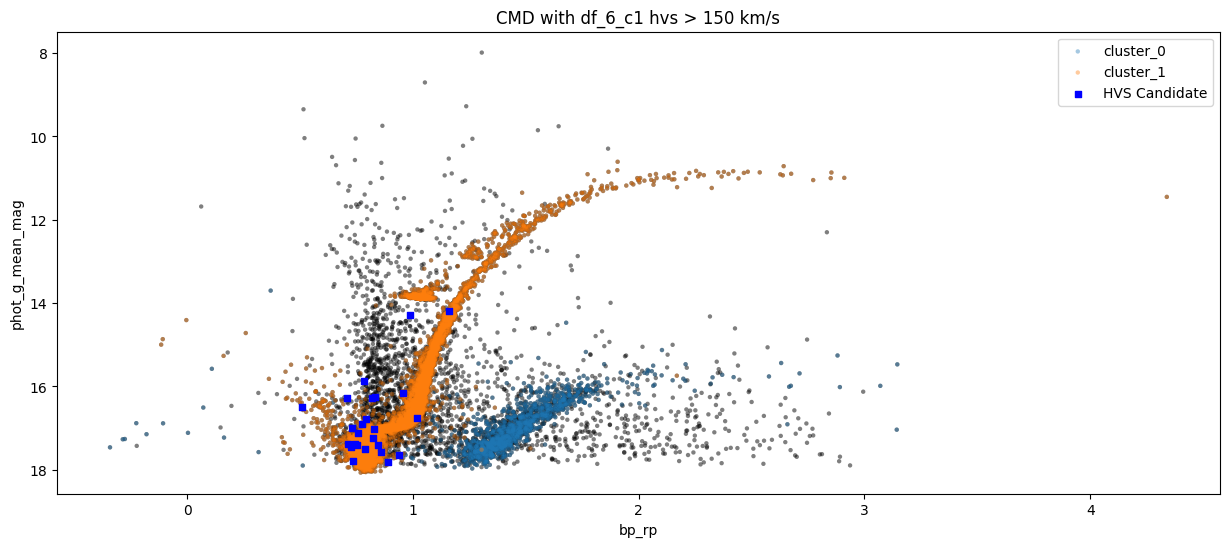

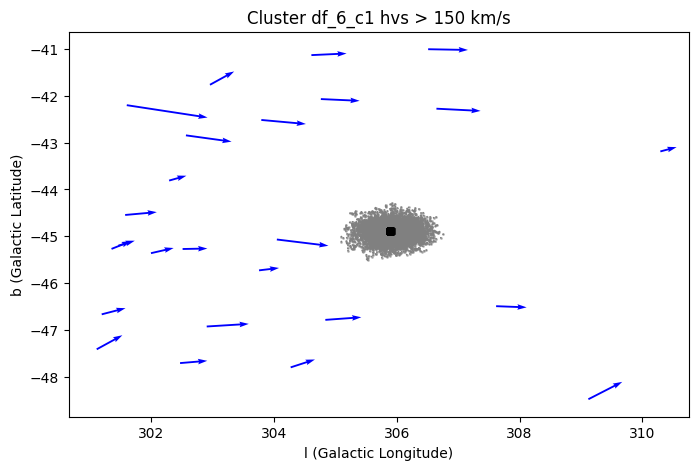

In [10]:
#project.clustering_results.set_main_label([0, 2])

fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=True,
            clusters=None
)

fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)

In [141]:
 clusters_dr2.loc[clusters_dr2.Name == "ngc 104", columns].iloc[0]

pmra                  5.250000
pmdec                -2.530000
parallax_corrected    0.225734
Name: 0, dtype: float32

In [142]:
get_distance_from_references(
    clustering.labels,
    clustering.df_stars,
    clusters_dr2.loc[clusters_dr2.Name == "ngc 104", columns].iloc[0],
    columns
)

array([2.41360053, 0.51279181, 0.54814895, 1.7352742 ])

In [ ]:
cluster_data = clustering.df_stars

In [116]:
project.clustering_results.get_labels(return_counts=True)

(array([0, 1, 2]), array([6470, 1805, 6546]))

In [117]:
project.clustering_results.main_label

2

In [8]:
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax_corrected", "radial_velocity"]].describe())

,pmra,pmdec,parallax_corrected,radial_velocity
count,13023.000000,13023.000000,13023.000000,1179.000000
mean,5.252898,-2.574561,0.225262,-17.261299
std,0.377229,0.387110,0.079227,10.628215
min,3.014429,-4.270577,-0.229236,-119.478880
25%,5.006501,-2.841742,0.183772,-22.671261
50%,5.249958,-2.580106,0.226230,-17.185257
75%,5.495934,-2.306255,0.264681,-12.396206
max,7.333937,-1.048327,0.673958,98.392784


In [9]:
#project.clustering_results.set_main_label(2)
gc = project.clustering_results.remove_outliers_gc()
display(gc[["pmra", "pmdec", "parallax_corrected", "radial_velocity"]].describe())

,pmra,pmdec,parallax_corrected,radial_velocity
count,12096.000000,12096.000000,12096.000000,1144.000000
mean,5.250367,-2.574245,0.224482,-17.370094
std,0.356611,0.369424,0.067102,10.124560
min,3.722795,-4.033533,-0.068837,-119.478880
25%,5.008433,-2.836410,0.186514,-22.772646
50%,5.249711,-2.578435,0.226028,-17.185848
75%,5.491515,-2.310801,0.262187,-12.332572
max,6.755563,-1.212391,0.504616,97.675360


In [12]:
project.save_project(to_zip=True)

client = storage.Client(project=os.getenv("PROJECT_ID"))
bucket = client.bucket(os.getenv("BUCKET"))
blob_path = project.astro_object.name+".zip"
path_zip = os.path.join(project.path, blob_path)

blob = bucket.blob(blob_path)
blob.upload_from_filename(path_zip)

In [1]:
gc = project.clustering_results.gc
gc

NameError: name 'project' is not defined

In [172]:
data.shape[0]

383

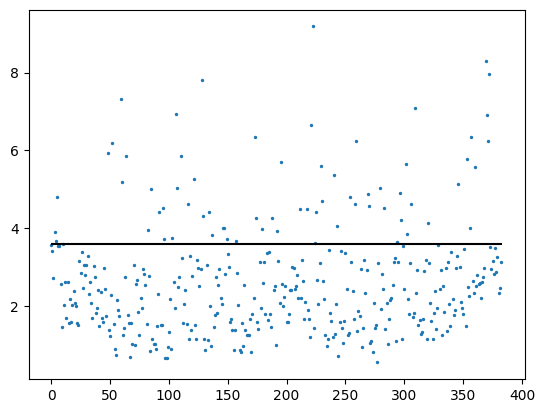

In [220]:
from sklearn.metrics import pairwise_distances
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

data = StandardScaler().fit_transform(gc[columns_to_clus])
cov = MinCovDet(random_state=0).fit(data)


mu = cov.location_
s = cov.covariance_
sinv = np.linalg.inv(s)local_outlier_method


dm = pairwise_distances(data, mu.reshape(1,-1), metric="mahalanobis", VI=sinv)

fig, ax = plt.subplots(1,1)
cutoff = np.sqrt(chi2.ppf(0.975, df=data.shape[1]))

ax.scatter(np.arange(data.shape[0]), dm, s=2)
ax.hlines(cutoff, 0, dm.size, color="k")

In [68]:
from sklearn.ensemble import IsolationForest

if_model = IsolationForest()
labels = if_model.fit_predict(gc[columns_to_clus])

In [242]:
from scipy.stats import shapiro

gc[columns_to_clus].apply(lambda x: shapiro(x))

,ra,dec,pmra,pmdec,parallax_corrected
0,0.992586,0.986857,9.331541e-01,9.437615e-01,0.983926
1,0.054586,0.001530,4.430513e-12,7.107507e-11,0.000291


(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         3.986e+03, 1.358e+03, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         3.941e+03, 1.403e+03, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.200e+01,
         4.624e+03, 7.050e+02, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.200e+01,
         4.701e+03, 6.160e+02, 2.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         4.583e+03, 7.450e+02, 1.400e+01, 2.000e+00]]),
 array([-35.22736387, -30.08865161, -24.94993935, -19.81122708,
        -14.67251482,  -9.53380256,  -4.39509029,   0.74362197,
          5.88233423,  11.0210465 ,  16.15975876]),
 <a list of 5 BarContainer objects>)

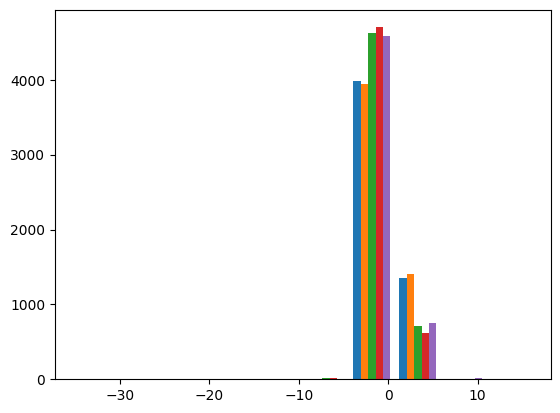

In [227]:
data_star[columns_to_clus].hist()

In [236]:
gc.loc[dm[:,0] <= cutoff, columns].describe()

,pmra,pmdec,parallax_corrected
count,315.000000,315.000000,315.000000
mean,-5.324308,-1.647525,0.130869
std,0.191324,0.179620,0.146306
min,-5.834781,-2.176810,-0.276135
25%,-5.437734,-1.744291,0.055935
50%,-5.334331,-1.651387,0.128485
75%,-5.203191,-1.551794,0.211997
max,-4.813859,-1.157888,0.557928


In [240]:
gc.loc[labels==1, columns].describe()

,pmra,pmdec,parallax_corrected
count,332.000000,332.000000,332.000000
mean,-5.324244,-1.666369,0.132237
std,0.223837,0.220102,0.152343
min,-6.016588,-2.436940,-0.288510
25%,-5.444455,-1.765689,0.053155
50%,-5.334947,-1.654959,0.128849
75%,-5.200457,-1.548128,0.219551
max,-4.298667,-1.080572,0.557928


In [237]:
gc.loc[:, columns].describe()

,pmra,pmdec,parallax_corrected
count,383.000000,383.000000,383.000000
mean,-5.335925,-1.687897,0.137530
std,0.318288,0.290626,0.171868
min,-6.665460,-2.952416,-0.368611
25%,-5.466017,-1.803859,0.048601
50%,-5.335797,-1.659648,0.132507
75%,-5.175670,-1.535223,0.244866
max,-3.926354,-0.861084,0.562496


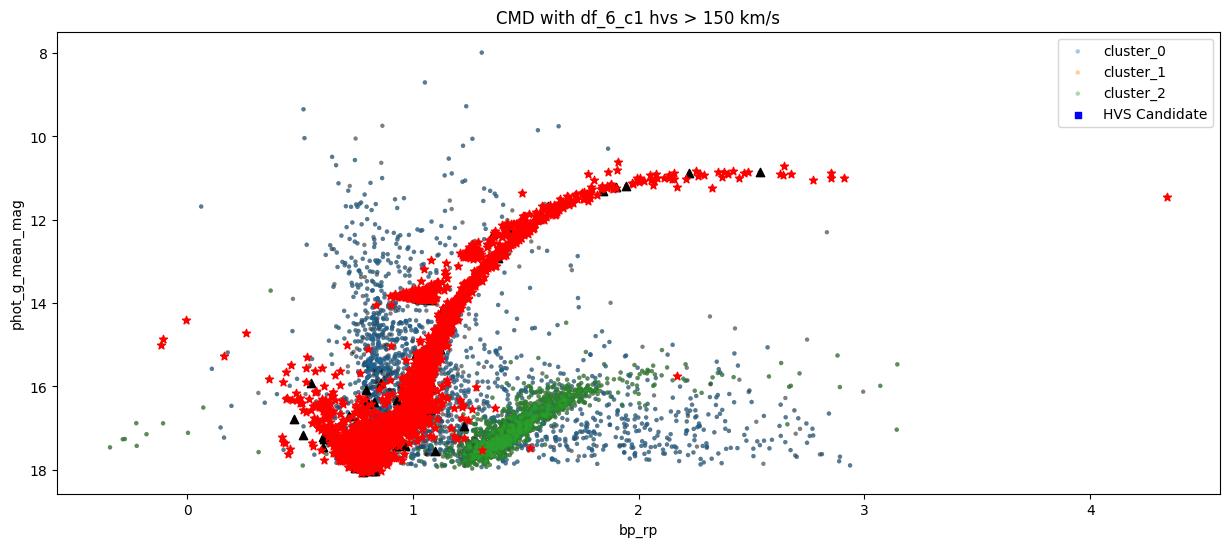

In [73]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 0,
            hvs_pm = 150,
            legend=True,
            clusters=None
)
if_model = IsolationForest()
labels = if_model.fit_predict(gc[columns_to_clus])

gc_selected = gc.loc[labels==1, :]
gc_not_selected = gc.loc[labels==-1, :]

ax.scatter(gc_not_selected["bp_rp"], gc_not_selected["phot_g_mean_mag"], marker="^", color="k")
ax.scatter(gc_selected["bp_rp"], gc_selected["phot_g_mean_mag"], marker="*", color="r")

In [72]:
gc_not_selected.shape

(1075, 159)

In [74]:
gc_selected.shape

(11975, 159)